This notebook shows the comparison between the Cherenkov light signal generated by CORSIKA IACT and that of CHASM for the same shower. First we import a CORSIKA IACT file using the eventio python module. I wrote a wrapper here for easier access to the CORSIKA IACT data. In order to make sure you have all the correct dependencies to run this demo, I included my python conda environment in the repository under "chpy.yml."

In [1]:
import numpy as np
from simulation import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import eventio

%matplotlib widget
  
corsika_file = '/home/isaac/corsika_data/unattenuated_30degree_sealevel/iact_s_000011.dat'
att_corsika_file = '/home/isaac/corsika_data/attenuated_30degree_sealevel/iact_s_000011.dat'
# corsika_file = 'IACT_shower_noatt.dat'
# att_corsika_file = 'IACT_shower_att.dat'
# corsika_file = '/home/isaac/corsika_data/correct_thinning/iact_DAT000001.dat'
# corsika_file = '/home/isaac/corsika_data/oldbuild_thinned/iact_DAT000001.dat'
corsika_file = '/home/isaac/corsika_data/old_build_diff_seed/iact_DAT000003.dat'

cors_no_att = EventioWrapper(corsika_file) #CORSIKA shower with no atmospheric absorbtion
cors_att = EventioWrapper(att_corsika_file) #CORSIKA shower with atmospheric absorbtion


Now we create a CHASM simulation, and add elements to it using the same parameters as the CORSIKA shower.

In [2]:
sim = ShowerSimulation()

#Add shower axis
sim.add(DownwardAxis(cors_no_att.theta, cors_no_att.phi, cors_no_att.obs))

#Add shower profile
sim.add(UserShower(cors_no_att.X, cors_no_att.nch)) #profiles could also be created using Gaisser-Hillas parameters

#Add CORSIKA IACT style spherical telescopes
sim.add(SphericalCounters(cors_no_att.counter_vectors, cors_no_att.counter_radius))

#Add wavelength interval for Cherenkov yield calculation
sim.add(Yield(cors_no_att.min_l, cors_no_att.max_l))


Now the simulation has all the necessary elements to calculate a Cherenkov signal.

In [3]:
#Create objects which calculate Cherekov signal
sim.run(mesh = True)

#Get signal photons
ng_sum = sim.get_signal_sum()

#Get attenuated signal photons
# ng_sum_att = sim.get_attenuated_signal_sum()

/home/isaac/testbuild/CHASM_NuSpacesim/cherenkov_photon_array.py:75: RuntimeWarning: invalid value encountered in power
  gg  = gg2[0]*(gg2[1]/gg2[0])**sd


Now let's plot the Cherenkov signal from both CORSIKA IACT and CHASM.

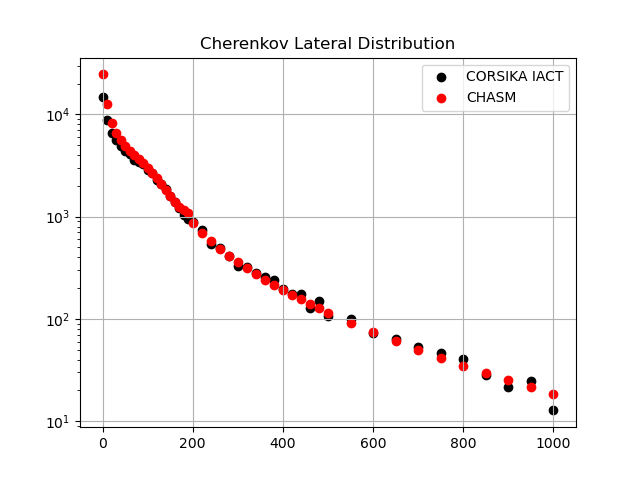

In [4]:
fig = plt.figure()
plt.scatter(cors_no_att.counter_r, cors_no_att.ng_sum, c = 'k', label = 'CORSIKA IACT');
# plt.scatter(cors_no_att.counter_r, cors_att.ng_sum, c = 'g', label = 'CORSIKA IACT (Attenuated)');
plt.scatter(cors_no_att.counter_r, ng_sum, c = 'r', label = 'CHASM');
# plt.scatter(cors_no_att.counter_r, ng_sum_att, c = 'b', label = 'CHASM (Attenuated)');
plt.semilogy();
plt.legend();
plt.grid()
plt.title('Cherenkov Lateral Distribution');

We can also compare the arrival time distributions of CHASM photons from each stage to that of the CORSIKA IACT photon bunches. For better modeling of the leading edge of the pulse, the CHASM mesh option samples the Cherenkov distribution at rings surrounding the axis, rather than just along the axis. Charged particles are distributed to each ring according to the universal energy-independent NKG distribution.

In [5]:
# times, photons = sim.get_signal_times()
# sim.run(mesh = True)
# mesh_times, mesh_photons = sim.get_attenuated_signal_times()
mesh_times, mesh_photons = sim.get_signal_times()

Now let's look at the arrival times for various counters at various distances from the shower core.

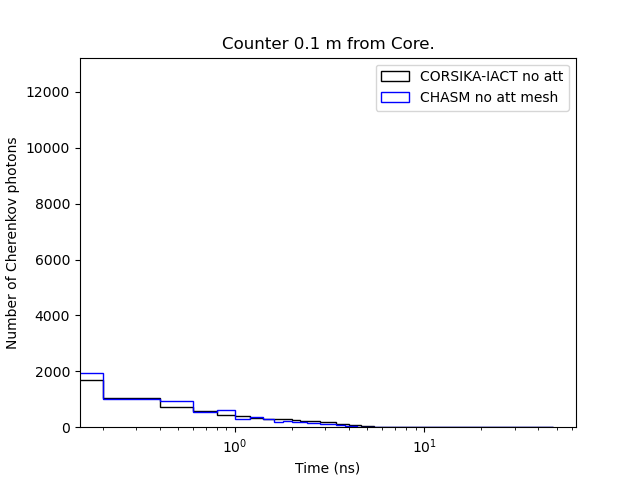

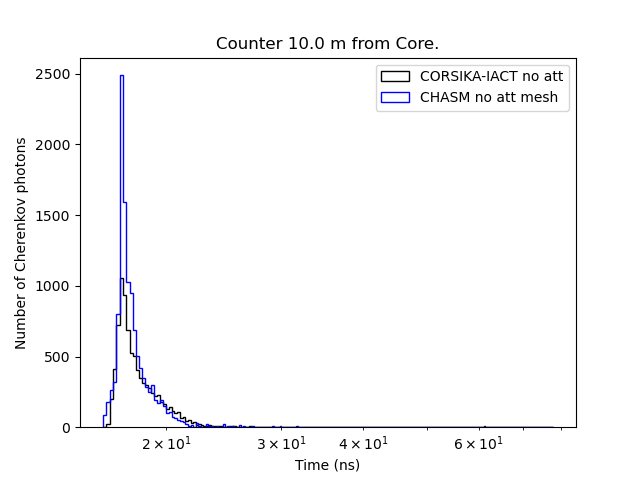

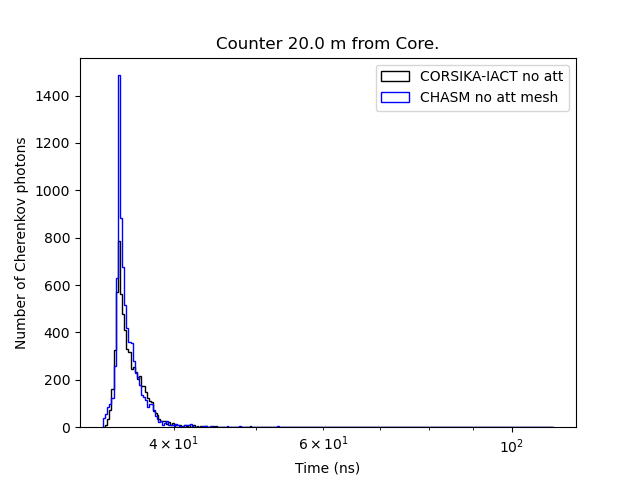

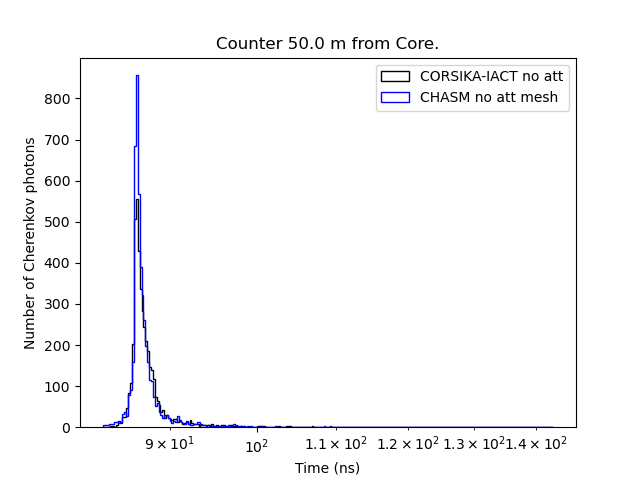

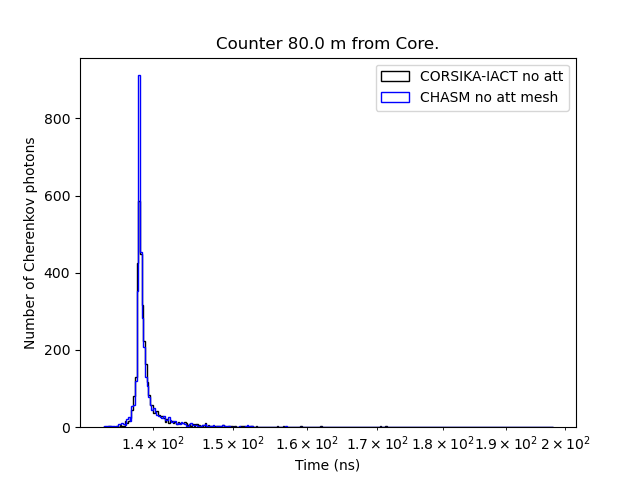

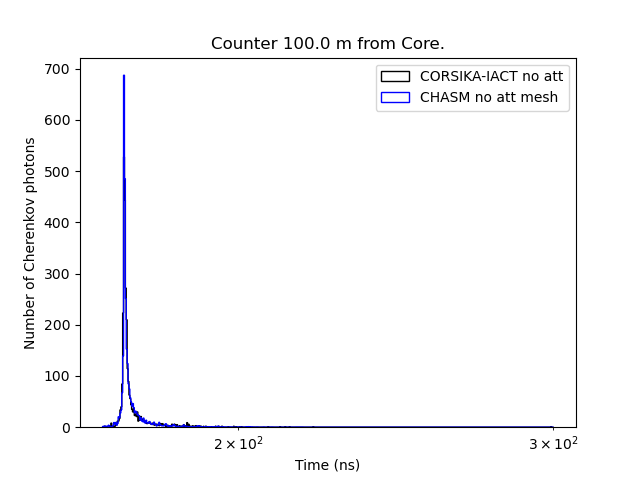

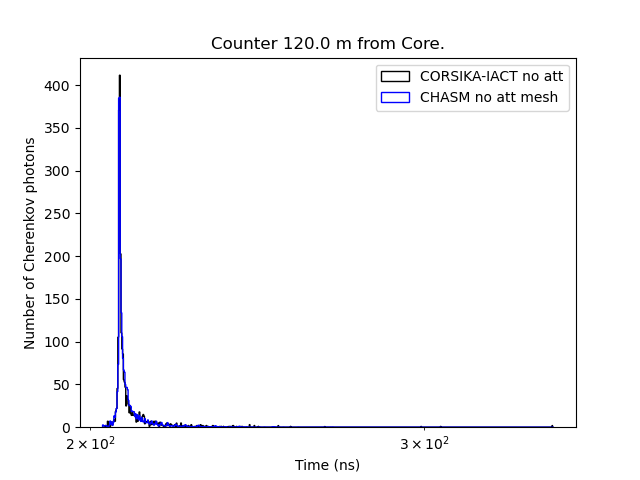

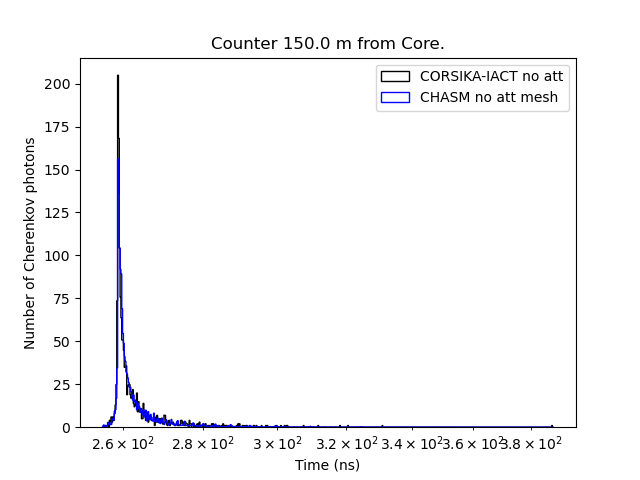

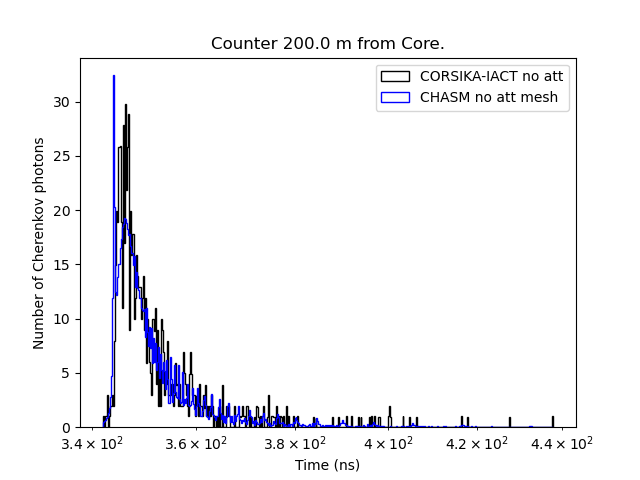

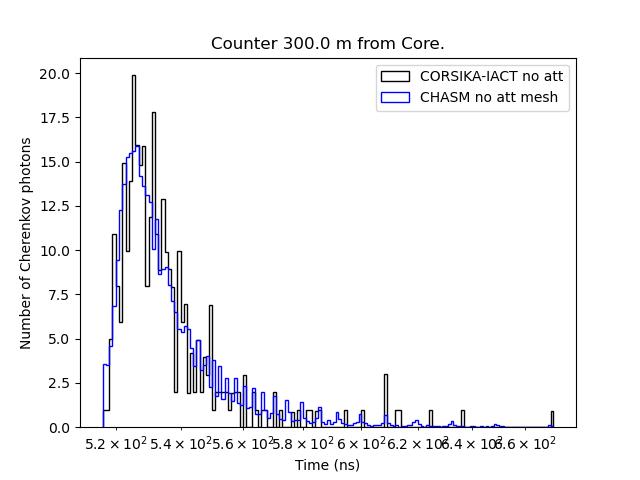

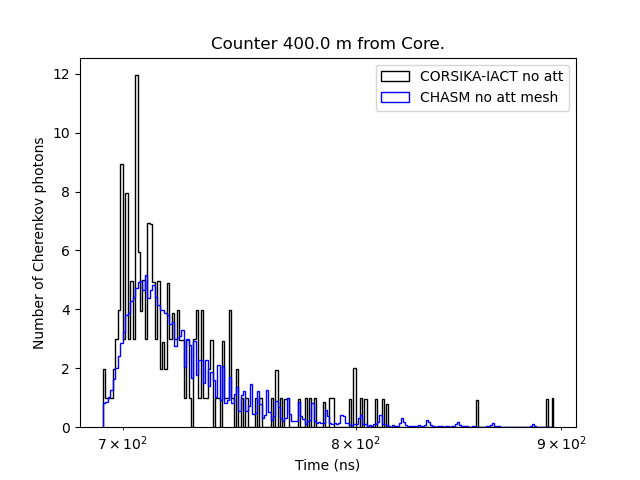

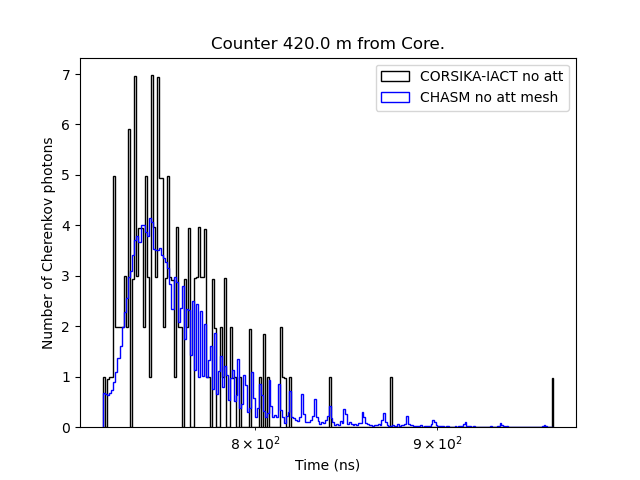

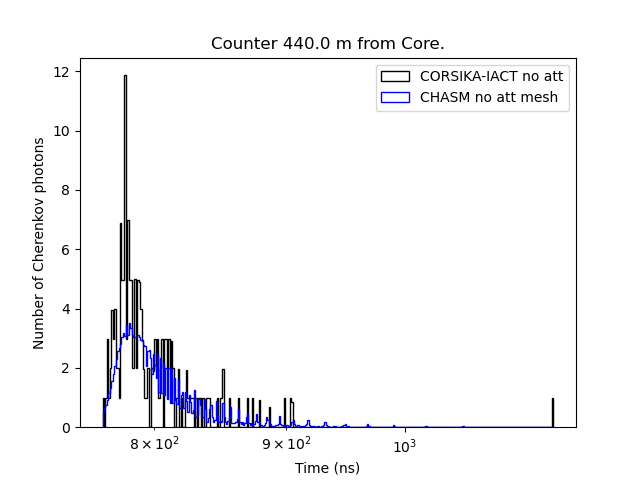

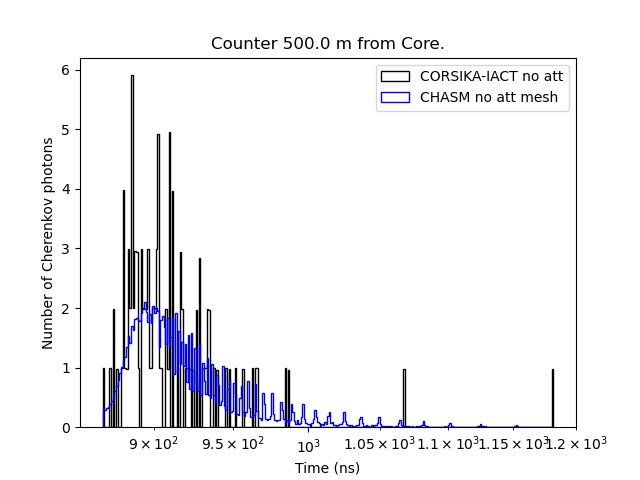

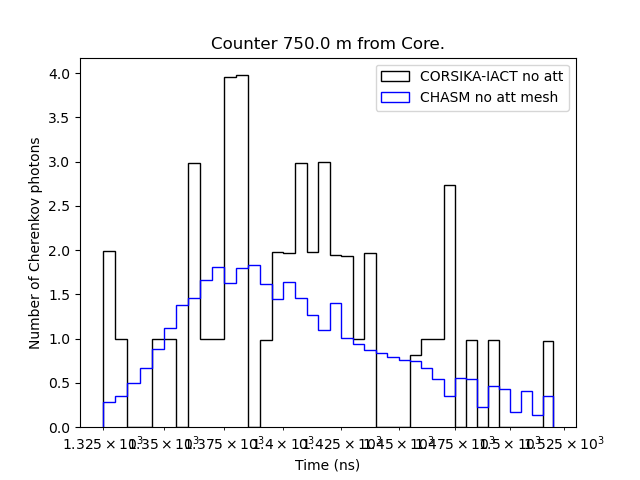

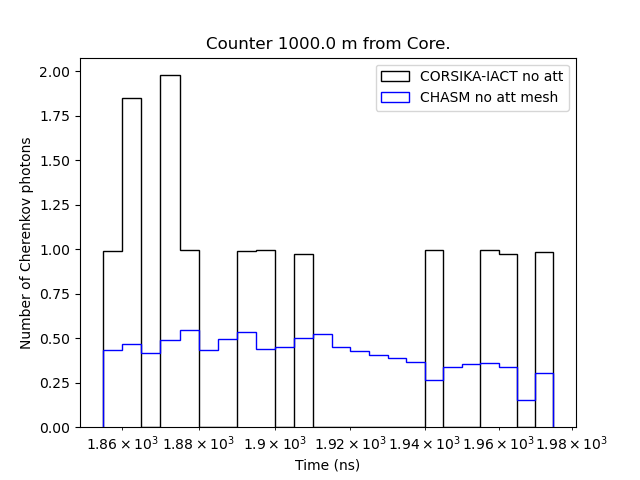

In [6]:
# counters_2_plot = np.array([1,5,10,20,30,40,45]) #indices of counters for which to plot arrival time distributions
counters_2_plot = np.array([0,1,2,5,8,10,12,15,20,25,30,31,32,35,40,45])
# counters_2_plot = np.arange(0,20)
for counter in counters_2_plot:
    fig = plt.figure()
    plt.hist(cors_no_att.get_photon_times(counter), cors_no_att.iact_ghnb[counter], (cors_no_att.iact_ghmn[counter],cors_no_att.iact_ghmx[counter]),
                          color='k',
                          weights=cors_no_att.get_photons(counter),
                          histtype='step',label='CORSIKA-IACT no att')
    plt.hist(mesh_times[counter], cors_no_att.iact_ghnb[counter], (cors_no_att.iact_ghmn[counter],cors_no_att.iact_ghmx[counter]),
                      color='b',
                      weights=mesh_photons[counter],
                      histtype='step',label='CHASM no att mesh')
#     plt.hist(times[counter], cors_no_att.iact_ghnb[counter], (cors_no_att.iact_ghmn[counter],cors_no_att.iact_ghmx[counter]),
#                       color='r',
#                       weights=photons[counter],
#                       histtype='step',label='CHASM no att')
    plt.xlabel('Time (ns)')
    plt.ylabel('Number of Cherenkov photons')
    plt.title(f'Counter {cors_no_att.counter_r[counter]:.1f} m from Core.')
    plt.semilogx()
    plt.legend()

The leading edge of the Cherenkov pulse comes earlier when Cherenkov light is sampled from physical charged particle positions because those points are closer to the counters than the axis itself. Here we plot the CORSIKA IACT photon bunch source locations along with the spread axis source locations, each weighted by the number of photons produced there.

array([102621.7734375 , 102617.9375    , 102609.328125  , ...,
         4506.69628906,   3363.87036133,   5865.49316406])

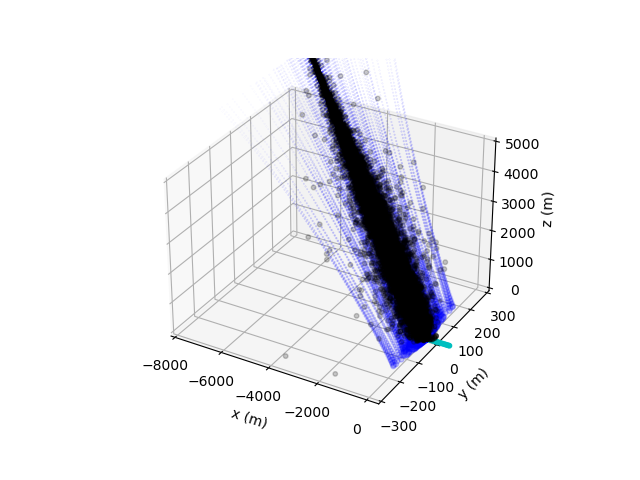

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
for s in sim.signals[:,0]:
    ng = s.calculate_ng()[0].sum(axis=0)
    ax.scatter(s.axis.vectors[:2000,0],s.axis.vectors[:2000,1],s.axis.vectors[:2000,2],c='b', s=100*ng[:2000]/ng[:2000].max(), alpha=0.2)
xb, yb, zb, pb = cors_no_att.shower_coordinates()
ax.scatter(xb,yb,zb,c='k', s=100*pb/ng[:2000].max(), alpha=0.2);
ax.scatter(cors_no_att.counter_vectors[:,0], cors_no_att.counter_vectors[:,1], cors_no_att.counter_vectors[:,2], c = 'c', s = 10);
ax.set_xlim(-8000,300);
ax.set_ylim(-300,300);
ax.set_zlim(0,5000);
ax.set_xlabel('x (m)');
ax.set_ylabel('y (m)');
ax.set_zlabel('z (m)');
zb

0.015108134597539902

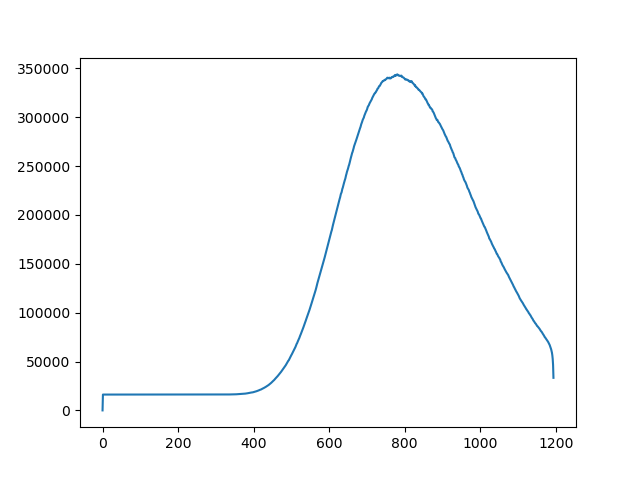

In [8]:
plt.figure()
plt.plot(cors_no_att.X,cors_no_att.nch)
zb.min()

In [9]:
cors_no_att.nch

array([    0., 16197., 16197., ..., 52716., 46528., 33324.], dtype=float32)

In [10]:
cors_no_att.X

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.192e+03, 1.193e+03,
       1.194e+03])

In [11]:
shower = sim.ingredients['shower'][0]
axis = sim.ingredients['axis'][0,0]
shower.stage(axis.X)

array([ 11.25223521,  10.92548843,  10.60140021,  10.27995401,
         9.96113331,   9.64492167,   9.33130275,   9.02026022,
         8.71177789,   8.40583958,   8.10242923,   7.80153081,
         7.50312839,   7.2072061 ,   6.91374813,   6.62273876,
         6.33416233,   6.04800324,   5.76424597,   5.48287506,
         5.20387514,   4.92723089,   4.65292707,   4.38094848,
         4.11128004,   3.84390668,   3.57881345,   3.31598543,
         3.05540779,   2.79706576,   2.54094463,   2.28702977,
         2.03530661,   1.78576064,   1.53837743,   1.29314262,
         1.05004189,   0.80906102,   0.57018583,   0.33340221,
         0.09869613,  -0.13394639,  -0.36453925,  -0.5930963 ,
        -0.81963133,  -1.04415803,  -1.26669007,  -1.48724102,
        -1.70582441,  -1.9224537 ,  -2.13714227,  -2.34990346,
        -2.56075053,  -2.76969669,  -2.97675507,  -3.18193875,
        -3.38526074,  -3.58673399,  -3.78637139,  -3.98418576,
        -4.18018988,  -4.37439643,  -4.56681806,  -4.75